In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap


from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# plot 설정
colors = sns.color_palette('pastel')[0:5]

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
warnings.filterwarnings(action='ignore')


In [2]:
def multicolumn(x: tuple):
    import re
    col_name = []
    for i in x :
        y = re.sub(r"\n","", i)
        if i.startswith('Unnamed'):
            continue
        if i.startswith('('):
            continue
        col_name.append(y)
    return '-'.join(col_name)


def df_scaler(df):
    return (df - df.min())/(df.max()-df.min())


## 신재생 에너지 생산량

In [3]:
# 에너지 생산량 - 2022
생활폐기물_에너지생산량 = pd.read_excel('./data/에너지생산량_폐기물에너지생활폐기물.xlsx', header = 1, index_col=(0,1))
생활폐기물_에너지생산량 = 생활폐기물_에너지생산량.xs(level=0,key='에너지생산량 (toe)', axis=0)
생활폐기물_에너지생산량 = 생활폐기물_에너지생산량.replace("-", np.nan).fillna(0)

# 소계분석
대구_신재생에너지생산량 = pd.read_excel('./data/신재생에너지생산량_대구.xlsx', header =  1, index_col=(0, 1, 2))
대구_신재생에너지생산량 = 대구_신재생에너지생산량.loc['재생에너지 (toe)'].xs('소계',level='에너지별(3)')
대구_신재생에너지생산량 = 대구_신재생에너지생산량.replace("-", np.nan).fillna(0)


Text(0, 0.5, '생산량')

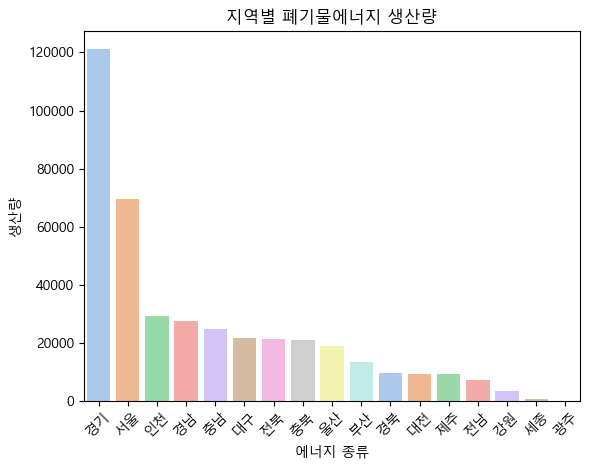

In [4]:
data = 생활폐기물_에너지생산량.iloc[:,1:].T.sort_values('소계', ascending=False)
data['지역'] = data.index

sns.barplot(data = data ,x = '지역' , y = '소계', palette='pastel')
plt.title('지역별 폐기물에너지 생산량')
plt.xticks(rotation=45)  
plt.xlabel('에너지 종류')
plt.ylabel('생산량')

Text(0, 0.5, '생산량')

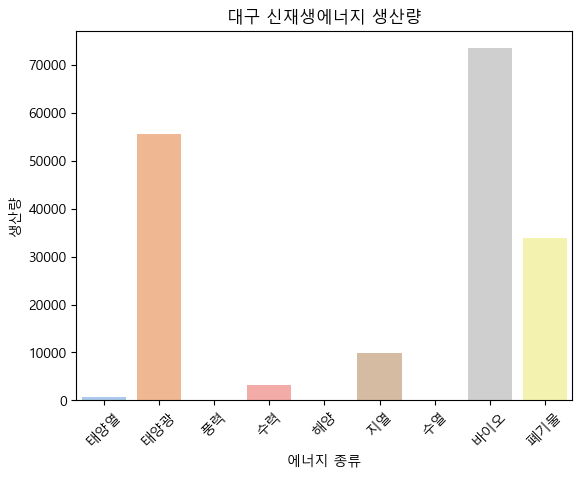

In [5]:
barplot = sns.barplot(data=대구_신재생에너지생산량['대구'], palette='pastel')
# 제목 및 레이블 설정
plt.title('대구 신재생에너지 생산량')
plt.xticks(rotation=45)  
plt.xlabel('에너지 종류')
plt.ylabel('생산량')


## 폐기물 관리시설

## 소각

In [6]:
폐기물관리시설 = pd.ExcelFile('./data/02_06_2022_전국 폐기물 처리업체현황_Ⅰ(생활, 사업장일반, 건설).xlsx')

공공소각 = 폐기물관리시설.parse('1-가. 공공소각', header = (3,4,5), index_col=(1,2))
공공소각.columns = tuple([(multicolumn(x)) for x in 공공소각.columns])
col = [
        '시설명',
        '시설용량',
        '1일평균가동시간',
        '소각방식',
        '운영방식',
        '2022년 처리량',
        '잔재물 발생 및 처리현황(톤/년)-계',
        '잔재물 발생 및 처리현황(톤/년)-재활용',
        '잔재물 발생 및 처리현황(톤/년)-소각',
        '잔재물 발생 및 처리현황(톤/년)-매립',
        '잔재물 발생 및 처리현황(톤/년)-기타',
        '설치비(백만원)-계',
        '설치비(백만원)-국비',
        '설치비(백만원)-지방비',
        '설치비(백만원)-기타',
        '연간유지관리비(백만원)',
        '관리인원(명)',

        '에너지발생량(Gcal)',
        '에너지 이용실태-총계(Gcal)',
        '에너지 이용실태-외부 공급(Gcal)-소계',
        '에너지 이용실태-외부 공급(Gcal)-열공급',
        '에너지 이용실태-외부 공급(Gcal)-전력공급',
        '에너지 이용실태-자체 사용(Gcal)-소계',
        '에너지 이용실태-자체 사용(Gcal)-열사용',
        '에너지 이용실태-자체 사용(Gcal)-전력사용',
 ]

공공소각 = 공공소각[col]

print(공공소각['소각방식'].value_counts())

소각방식
일반소각            165
열분해시설(가스화포함)     11
고온소각              7
고온용융              6
열처리조합시설           1
Name: count, dtype: int64


In [7]:
# 공공소각 데이터 지역별, 개별로 분리
공공소각_지역별_소계 = 공공소각[(공공소각.index.get_level_values(1) == '소계')].droplevel(1)
공공소각_개별 = 공공소각[~(공공소각.index.get_level_values(1) == '소계')].iloc[1:]
공공소각_개별= 공공소각_개별.droplevel(1)
공공소각_개별['지역'] = 공공소각_개별.index

# 이상 데이터 제거 및 Feature 생성
공공소각_개별 = 공공소각_개별[공공소각_개별['2022년 처리량']> 0]
공공소각_개별 = 공공소각_개별[공공소각_개별['관리인원(명)']> 0]
공공소각_개별 = 공공소각_개별[공공소각_개별['설치비(백만원)-계'] > 0]

공공소각_개별['에너지발생여부'] = None

공공소각_개별.loc[공공소각_개별['에너지발생량(Gcal)']>0, '에너지발생여부'] = 'O'
공공소각_개별.loc[공공소각_개별['에너지발생량(Gcal)']<=0, '에너지발생여부'] = 'X'


공공소각_개별['임시효율'] = np.where(공공소각_개별['에너지발생량(Gcal)'] == 0, 
                                     1e-3, 
                                      공공소각_개별['에너지 이용실태-총계(Gcal)']/공공소각_개별['에너지발생량(Gcal)'] )
공공소각_개별['소각효율']= (공공소각_개별['2022년 처리량']-공공소각_개별['잔재물 발생 및 처리현황(톤/년)-계'])/ (공공소각_개별['2022년 처리량']) 
공공소각_개별['가동시간효율']= (공공소각_개별['2022년 처리량'])/ (공공소각_개별['1일평균가동시간']) 
공공소각_개별['인력효율']= (공공소각_개별['2022년 처리량'])/ (공공소각_개별['관리인원(명)'])    # 0
공공소각_개별['경제효율']= (공공소각_개별['2022년 처리량'])/ (공공소각_개별['설치비(백만원)-계']) # 0
공공소각_개별[['임시효율','소각효율','가동시간효율','경제효율','인력효율']] =\
      공공소각_개별[['임시효율','소각효율','가동시간효율','경제효율','인력효율']].apply(df_scaler, axis=0)


# 가중치 설정
weights = {
    '임시효율': 0.2,
    '소각효율': 0.2,
    '가동시간효율': 0.2,
    '경제효율': 0.2,
    '인력효율': 0.2
}

# 각 지표에 가중치를 곱한 후 합산하여 총 점수 계산
공공소각_개별['총점수_가중치'] = (공공소각_개별[list(weights.keys())] * pd.Series(weights)).sum(axis=1)

# 인덱스 정리, 평균 데이터 생성
공공소각_개별 =공공소각_개별.drop_duplicates(subset='시설명')
공공소각_개별 =공공소각_개별.set_index('시설명')

공공소각_평균 = pd.DataFrame(공공소각_개별.groupby('지역').describe()).xs(level=1, key = 'mean', axis=1)



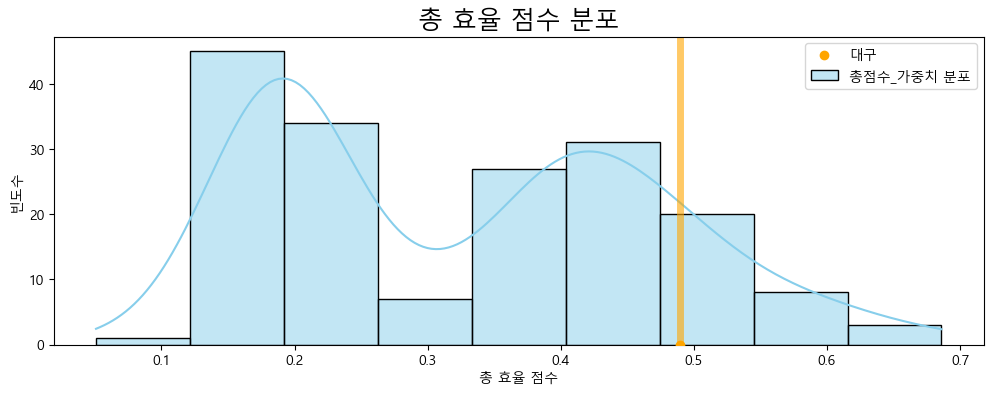

In [8]:
# '소각효율' 분포 시각화
plt.figure(figsize=(12, 4)) 

# 히스토그램으로 소각효율 분포를 시각화
sns.histplot(공공소각_개별['총점수_가중치'], kde=True, color='skyblue', label='총점수_가중치 분포')

# 최소값과 최대값
min_value = 공공소각_개별['총점수_가중치'].min()
max_value = 공공소각_개별['총점수_가중치'].max()

# 위치가 대구인 데이터 포인트 강조
대구_data = 공공소각_개별[공공소각_개별['지역'] == '대구']
plt.scatter(대구_data['총점수_가중치'], np.zeros_like(대구_data['총점수_가중치']), color='orange', label='대구', zorder=5)

# 대구 데이터에 줄선 그리기
for eff in 대구_data['총점수_가중치']:
    plt.axvline(eff, color='orange', linestyle='-', linewidth=5, alpha=0.6)

# x축의 최솟값을 40으로 설정
#plt.xlim(left=0.4)

# 레전드 추가
plt.legend()

# 제목 및 레이블 설정
plt.title('총 효율 점수 분포', size = 18)
plt.xlabel('총 효율 점수')
plt.ylabel('빈도수')

# 그래프 표시
plt.show()

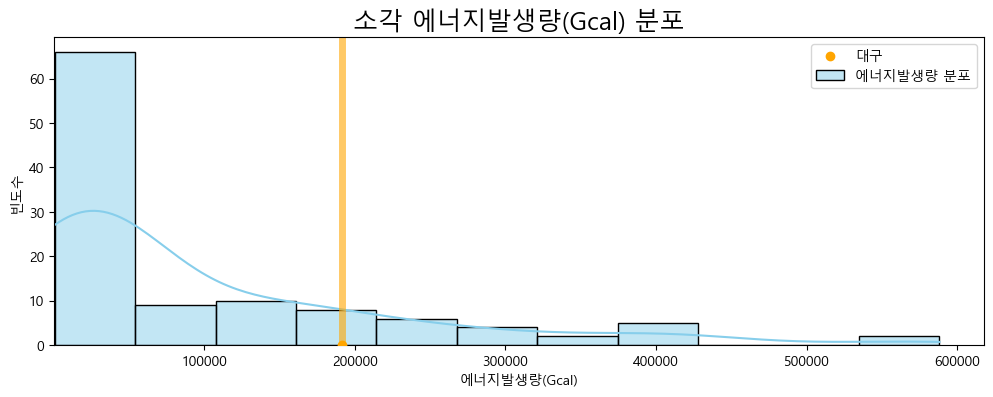

In [9]:
# '에너지발생량(Gcal)' 분포 시각화
plt.figure(figsize=(12, 4)) 

# 히스토그램으로 소각효율 분포를 시각화
sns.histplot(공공소각_개별[공공소각_개별['에너지발생량(Gcal)']>1]['에너지발생량(Gcal)'], kde=True, color='skyblue', label='에너지발생량 분포')


# 위치가 대구인 데이터 포인트 강조
대구_data = 공공소각_개별[공공소각_개별['지역'] == '대구']
plt.scatter(대구_data['에너지발생량(Gcal)'], np.zeros_like(대구_data['에너지발생량(Gcal)']), color='orange', label='대구', zorder=5)

# 대구 데이터에 줄선 그리기
for eff in 대구_data['에너지발생량(Gcal)']:
    plt.axvline(eff, color='orange', linestyle='-', linewidth=5, alpha=0.6)

# x축의 최솟값을 40으로 설정
plt.xlim(left=0.4)
# 레전드 추가
plt.legend()

# 제목 및 레이블 설정
plt.title('소각 에너지발생량(Gcal) 분포', size= 18)
plt.xlabel('에너지발생량(Gcal)')
plt.ylabel('빈도수')

# 그래프 표시
plt.show()

In [10]:

# 머신러닝 모델을 통한 해석
# 데이터 전처리
onehot1 = pd.get_dummies(공공소각_개별['운영방식'], prefix='운영방식',prefix_sep='-',dummy_na=False, dtype='int')
onehot2 = pd.get_dummies(공공소각_개별['소각방식'], prefix='소각방식',prefix_sep='-',dummy_na=False, dtype='int')

data = pd.concat([공공소각_개별, onehot1, onehot2],axis=1)
data = data.drop(['소각방식', '운영방식'], axis=1)

data = data.dropna(subset=['소각효율'])


continue_feature = ['1일평균가동시간', 
                    '2022년 처리량',  
                    '설치비(백만원)-계',
                    '연간유지관리비(백만원)',
                 '관리인원(명)'
                 ] #,'에너지발생량(Gcal)'
categorical_feature = [ '운영방식-연속식', '운영방식-준연속식', '운영방식-회분식', 
                       '소각방식-고온소각', '소각방식-고온용융', '소각방식-열분해시설(가스화포함)', 
                       '소각방식-열처리조합시설', '소각방식-일반소각']

label_feature=['임시효율','소각효율','인력효율','경제효율'] # '잔재물 발생 및 처리현황(톤/년)-계',

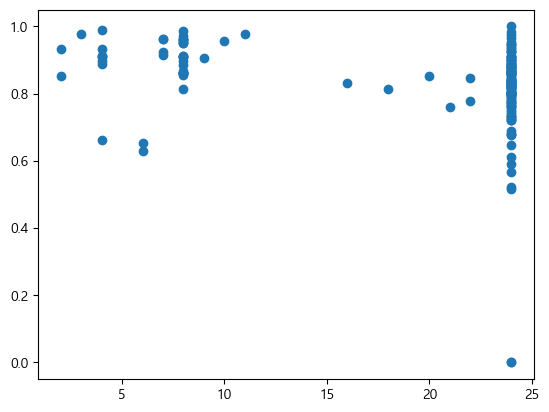

In [11]:
plt.scatter(x = data['1일평균가동시간'], y = data['소각효율'])

Extra Trees Regressor - MAE: 0.05562915409425045, R^2 Score: 0.6503540953543574
XGBoost Regressor - MAE: 0.06167869630754494, R^2 Score: 0.5324547461857432


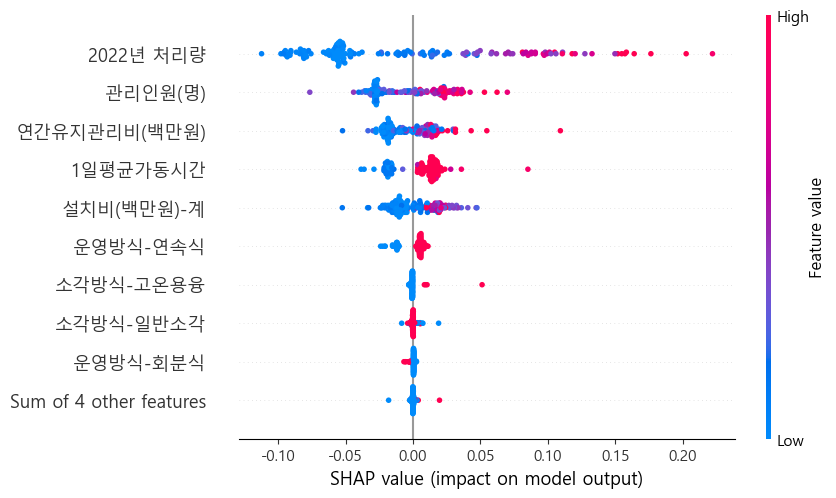

In [12]:
scaler = MinMaxScaler()

x = data[categorical_feature+continue_feature]
scaler.fit(x[continue_feature])
x[continue_feature] = scaler.transform(x[continue_feature])

y = data['총점수_가중치']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=4)

# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=42).fit(X_train, y_train)
pred_etr = etr.predict(X_test)
mae_etr = mean_absolute_error(y_test, pred_etr)
r2_etr = etr.score(X_test, y_test)
print(f'Extra Trees Regressor - MAE: {mae_etr}, R^2 Score: {r2_etr}')

# XGBoost Regressor
xgbr = XGBRegressor(random_state=42).fit(X_train, y_train)
pred_xgbr = xgbr.predict(X_test)
mae_xgbr = mean_absolute_error(y_test, pred_xgbr)
r2_xgbr = xgbr.score(X_test, y_test)
print(f'XGBoost Regressor - MAE: {mae_xgbr}, R^2 Score: {r2_xgbr}')

ex = shap.Explainer(etr)

shap_v = ex(X_train)



shap.initjs()
shap.plots.beeswarm(shap_v)

Extra Trees Regressor - MAE: 0.05562915409425045, R^2 Score: 0.6503540953543574
XGBoost Regressor - MAE: 0.06167869630754494, R^2 Score: 0.5324547461857432


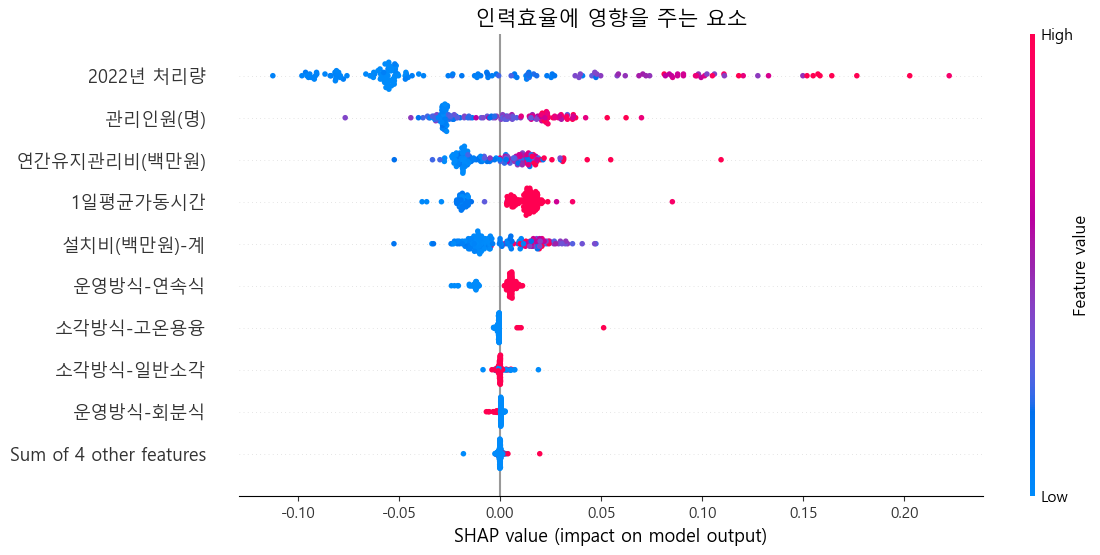

In [13]:
scaler = MinMaxScaler()

x = data[categorical_feature+continue_feature]
scaler.fit(x[continue_feature])
x[continue_feature] = scaler.transform(x[continue_feature])

y = data['총점수_가중치']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=4)

# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=42).fit(X_train, y_train)
pred_etr = etr.predict(X_test)
mae_etr = mean_absolute_error(y_test, pred_etr)
r2_etr = etr.score(X_test, y_test)
print(f'Extra Trees Regressor - MAE: {mae_etr}, R^2 Score: {r2_etr}')

# XGBoost Regressor
xgbr = XGBRegressor(random_state=42).fit(X_train, y_train)
pred_xgbr = xgbr.predict(X_test)
mae_xgbr = mean_absolute_error(y_test, pred_xgbr)
r2_xgbr = xgbr.score(X_test, y_test)
print(f'XGBoost Regressor - MAE: {mae_xgbr}, R^2 Score: {r2_xgbr}')

ex = shap.Explainer(etr)

shap_v = ex(X_train)


shap.initjs()
ax = shap.plots.beeswarm(shap_v, plot_size=(12, 6),show=False)
plt.title('인력효율에 영향을 주는 요소', size = 15)
plt.show()

## 매립

In [14]:
공공매립 = 폐기물관리시설.parse('1-다. 공공매립', header = (3,4,5,6), index_col=(1,2))
공공매립.columns =  tuple([(multicolumn(x)) for x in 공공매립.columns])
공공매립.loc[공공매립['잔여매립가능량']<0.0,'잔여매립가능량'] = 0.0


공공매립_개별 = 공공매립[~(공공매립.index.get_level_values(1) == '소계')].iloc[1:]

공공매립_개별= 공공매립_개별.droplevel(1)
공공매립_개별['지역'] = 공공매립_개별.index

col = [ '승인·허가내용-면적(㎡)', 
        '기매립량(2022년까지전체 누적)', 
        '잔여매립가능량',
       '2022년 매립량(생활/사업장폐기물)',
       '설치비 (백만원)-계',
        '연간유지관리비(백만원)',
       '매립지관리인원(명)', 
       '발생가스 에너지 이용 실태-발생가스(LFG) 포집량-발생가스총포집량(N㎥/년)',
       '발생가스 에너지 이용 실태-발생가스(LFG) 포집량-발생가스 총포집량 중메탄가스량(N㎥/년)',
       '발생가스 에너지 이용 실태-메탄가스 (CH4) 활용량-에너지생산-총활용량(N㎥/년)',
       '발생가스 에너지 이용 실태-메탄가스 (CH4) 활용량-에너지생산-발전(N㎥/년)',
       '발생가스 에너지 이용 실태-메탄가스 (CH4) 활용량-에너지생산-냉난방(N㎥/년)',
       '발생가스 에너지 이용 실태-메탄가스 (CH4) 활용량-에너지생산-가스공급(N㎥/년)',
       '발생가스 에너지 이용 실태-메탄가스 (CH4) 활용량-에너지생산-기타(N㎥/년)',
       '발생가스 에너지 이용 실태-메탄가스 (CH4) 활용량-에너지생산 외', '지역'
]

rename_col = [ '승인·허가내용-면적(㎡)', 
        '기매립량(2022년까지전체 누적)-㎡', 
        '잔여매립가능량-㎡',
       '2022년 매립량(생활/사업장폐기물)(㎡)',
       '2022년 매립량(생활/사업장폐기물)(ton)',
       '설치비 (백만원)-계',
        '연간유지관리비(백만원)',
       '매립지관리인원(명)', 
       '발생가스 총포집량(N㎥/년)',
       '발생가스 총포집량 중 메탄가스량(N㎥/년)',
       '메탄가스 (CH4) 활용량-총활용량(N㎥/년)',
       '메탄가스 (CH4) 활용량-발전(N㎥/년)',
       '메탄가스 (CH4) 활용량-냉난방(N㎥/년)',
       '메탄가스 (CH4) 활용량-가스공급(N㎥/년)',
       '메탄가스 (CH4) 활용량-기타(N㎥/년)',
       '메탄가스 (CH4) 활용량-에너지생산 외', 
       '지역'
]


공공매립_개별 = 공공매립_개별[col]
공공매립_개별.columns = rename_col
공공매립 = 공공매립[col[:-1]]
공공매립.columns = 공공매립_개별.columns[:-1]
공공매립_지역별_소계 = 공공매립[(공공매립.index.get_level_values(1) == '소계')].droplevel(1)

공공매립_평균 = pd.DataFrame(공공매립_개별.groupby('지역').describe()).xs(axis=1, level=1,key='mean')
공공매립_평균['지역'] = 공공매립_평균.index


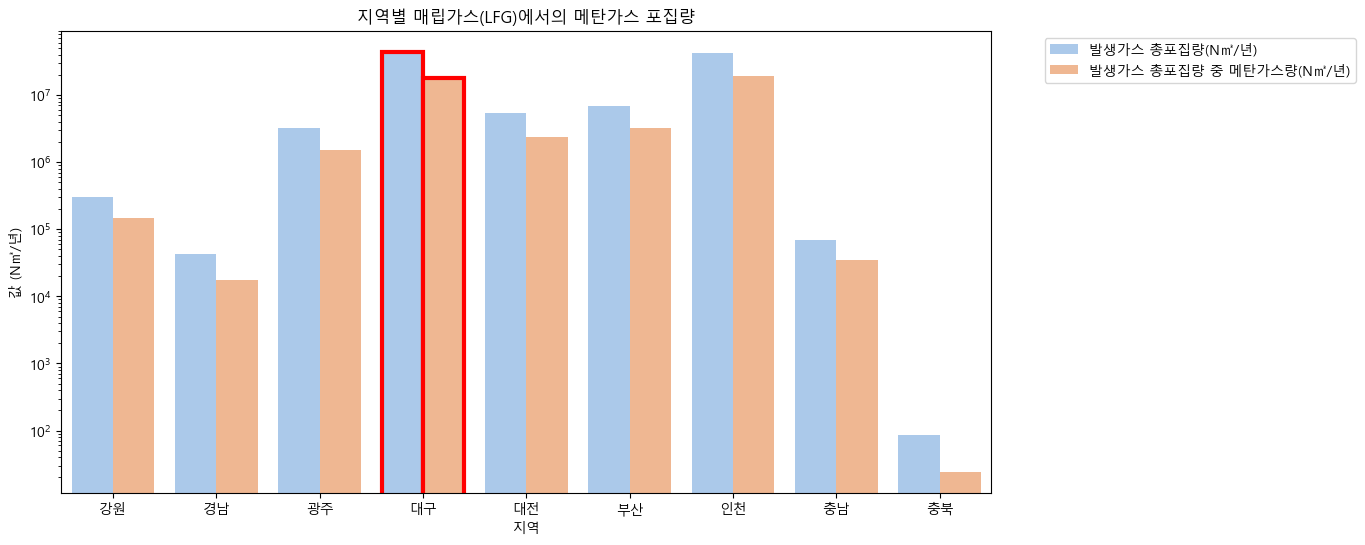

In [15]:
# 매립가스 시각화
df = 공공매립_평균[공공매립_평균['발생가스 총포집량 중 메탄가스량(N㎥/년)']>0.0]

df_melted = df.melt(id_vars='지역', value_vars=['발생가스 총포집량(N㎥/년)','발생가스 총포집량 중 메탄가스량(N㎥/년)'],
                    var_name='항목', value_name='값')

plt.figure(figsize=(12, 6))

barplot = sns.barplot(x='지역', y='값', hue='항목', data=df_melted, palette='pastel')

# 강조를 위해 대구의 바에 테두리 추가
for patch, region in zip(barplot.patches, df_melted['지역']):
    if region == '대구':
        patch.set_linewidth(3)
        patch.set_edgecolor('red')  # 테두리 색상

# 제목 및 레이블 설정
plt.title('지역별 매립가스(LFG)에서의 메탄가스 포집량')
plt.yscale('log') 
plt.xlabel('지역')
plt.ylabel('값 (N㎥/년)')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## 공공기타

In [16]:
공공기타 = 폐기물관리시설.parse('1-나. 공공기타', header = (3,4,5,6), index_col=(1,2))
공공기타.columns =  tuple([(multicolumn(x)) for x in 공공기타.columns])
공공기타_지역별_소계 = 공공기타[(공공기타.index.get_level_values(1) == '소계')].droplevel(1)#.iloc[1:]
공공기타_개별 = 공공기타[~(공공기타.index.get_level_values(1) == '소계')].iloc[1:]
공공기타_개별= 공공기타_개별.droplevel(1)
공공기타_개별['지역'] = 공공기타_개별.index
col = [
       '시설명', 
       '시설용량', 
       '1일평균가동시간', 
       '2022년 처리량', 
       '잔재물 발생 및 처리현황(톤/년)-계',
       '잔재물 발생 및 처리현황(톤/년)-재활용', '잔재물 발생 및 처리현황(톤/년)-소각',
       '잔재물 발생 및 처리현황(톤/년)-매립', '잔재물 발생 및 처리현황(톤/년)-기타', 
       '설치비 (백만원)-계', '연간유지관리비(백만원)',
       '발생가스 이용현황-발생가스 포집량-발생가스총포집량(N㎥/년)',
       '발생가스 이용현황-발생가스 포집량-발생가스 총포집량 중메탄가스량(N㎥/년)',
       '발생가스 이용현황-메탄가스 (CH4) 활용량-에너지생산-총활용량(N㎥/년)',
       '발생가스 이용현황-메탄가스 (CH4) 활용량-에너지생산-발전(N㎥/년)',
       '발생가스 이용현황-메탄가스 (CH4) 활용량-에너지생산-냉난방(N㎥/년)',
       '발생가스 이용현황-메탄가스 (CH4) 활용량-에너지생산-가스공급(N㎥/년)',
       '발생가스 이용현황-메탄가스 (CH4) 활용량-에너지생산-기타(N㎥/년)',
       '발생가스 이용현황-메탄가스 (CH4) 활용량-에너지생산 외','지역']

공공기타_개별 = 공공기타_개별[col]
rename_col = [
       '시설명', 
       '시설용량', 
       '1일평균가동시간', 
       '2022년 처리량', 
       '잔재물 발생 및 처리현황(톤/년)-계',
       '잔재물 발생 및 처리현황(톤/년)-재활용', '잔재물 발생 및 처리현황(톤/년)-소각',
       '잔재물 발생 및 처리현황(톤/년)-매립', '잔재물 발생 및 처리현황(톤/년)-기타', 
       '설치비 (백만원)-계', '연간유지관리비(백만원)',
       '발생가스 총포집량(N㎥/년)',
       '발생가스 총포집량 중 메탄가스량(N㎥/년)',
       '메탄가스 (CH4) 활용량-총활용량(N㎥/년)',
       '메탄가스 (CH4) 활용량-발전(N㎥/년)',
       '메탄가스 (CH4) 활용량-냉난방(N㎥/년)',
       '메탄가스 (CH4) 활용량-가스공급(N㎥/년)',
       '메탄가스 (CH4) 활용량-기타(N㎥/년)',
       '메탄가스 (CH4) 활용량-에너지생산 외', 
        '지역']

공공기타_개별.columns = rename_col

공공기타_개별 = 공공기타_개별[공공기타_개별['2022년 처리량']> 0]

공공기타_개별 = 공공기타_개별[공공기타_개별['1일평균가동시간']> 0]
공공기타_개별 = 공공기타_개별[공공기타_개별['연간유지관리비(백만원)'] > 0]

공공기타_개별['포집효율'] = np.where(공공기타_개별['발생가스 총포집량(N㎥/년)'] == 0.0, 
                                     1e-5, 
                                      공공기타_개별['발생가스 총포집량 중 메탄가스량(N㎥/년)']/공공기타_개별['발생가스 총포집량(N㎥/년)'] )
공공기타_개별['처리효율']= (공공기타_개별['2022년 처리량']-공공기타_개별['잔재물 발생 및 처리현황(톤/년)-계'])/ (공공기타_개별['2022년 처리량'])
공공기타_개별['가동시간효율']= (공공기타_개별['2022년 처리량'])/ (공공기타_개별['1일평균가동시간']) 
공공기타_개별['경제효율']= (공공기타_개별['2022년 처리량'])/ (공공기타_개별['연간유지관리비(백만원)']) # 0


공공기타_개별[['포집효율','가동시간효율','경제효율']] =\
      공공기타_개별[['포집효율','가동시간효율','경제효율']].apply(df_scaler, axis=0)
# 가중치 설정
weights = {
    '포집효율': 0.2,
    '처리효율': 0.2,
    '가동시간효율': 0.2,
    '경제효율': 0.2,
}

# 각 지표에 가중치를 곱한 후 합산하여 총 점수 계산
공공기타_개별['총점수_가중치'] = (공공기타_개별[list(weights.keys())] * pd.Series(weights)).sum(axis=1)

# 평균데이터
공공기타_평균 = 공공기타_개별.groupby('지역').describe().xs(level = 1, axis=1,key='mean')
공공기타_평균['지역'] = 공공기타_평균.index



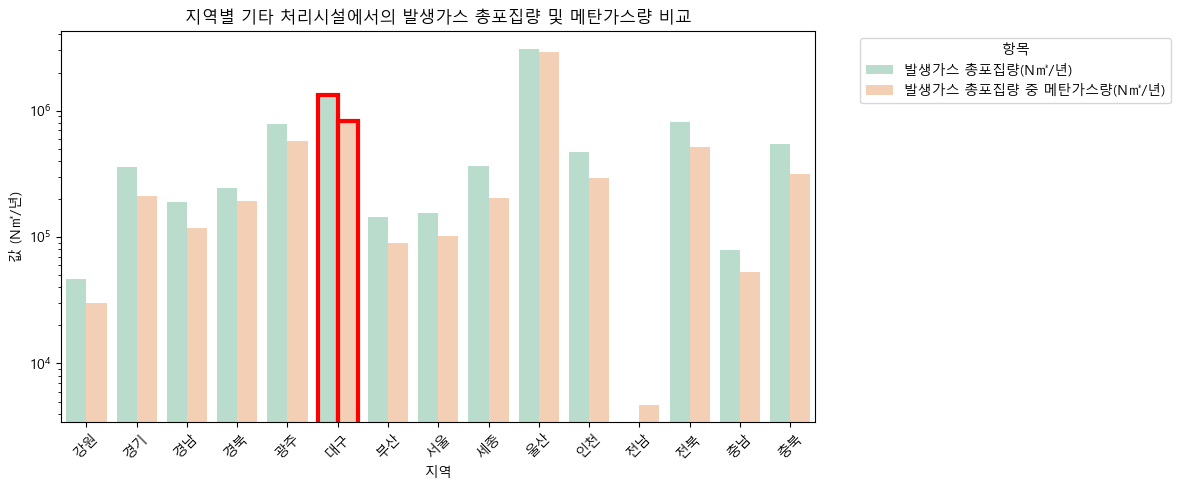

In [17]:
# 지역별 발생가스 포집량 비교
df = 공공기타_평균[공공기타_평균['발생가스 총포집량 중 메탄가스량(N㎥/년)']>0.0]

df_melted = df.melt(id_vars='지역', value_vars=['발생가스 총포집량(N㎥/년)','발생가스 총포집량 중 메탄가스량(N㎥/년)'],
                    var_name='항목', value_name='값')

# '대구' 강조를 위해 색상을 변경하기 위한 함수 정의
def highlight_region(row, region_name):
    return 'red' if row['지역'] == region_name else 'gray'

# 대구를 강조하기 위한 색상 설정
df_melted['color'] = df_melted.apply(lambda row: highlight_region(row, '대구'), axis=1)

# 시각화
plt.figure(figsize=(12, 5))  # x축 간격을 넓히기 위해 가로 크기 조정

# Barplot 그리기
barplot = sns.barplot(x='지역', y='값', hue='항목', data=df_melted,  palette='Pastel2')

# 제목 및 레이블 설정
plt.title('지역별 기타 처리시설에서의 발생가스 총포집량 및 메탄가스량 비교')
plt.yscale('log')  # 로그 스케일 적용
plt.xlabel('지역')
plt.ylabel('값 (N㎥/년)')
plt.xticks(rotation=45)  # x축 라벨 회전 각도 조정
plt.legend(title='항목', bbox_to_anchor=(1.05, 1), loc='upper left')

# 강조를 위해 대구의 바에 테두리 추가
for patch, region in zip(barplot.patches, df_melted['지역']):
    if region == '대구':
        patch.set_linewidth(3)
        patch.set_edgecolor('red')  # 테두리 색상

plt.tight_layout()  # 전체 레이아웃 조정
plt.show()

## 폐기물 발생과 재활용 분석

In [19]:
def create_col(df):
    name = df['level_1']
    if not df['level_2'] =='EMPTY':
        name += '_' + df['level_2']
    if not df['level_3'] == 'EMPTY':
        name += '_' + df['level_3']
    return name


인구수 = pd.read_excel('./data/행정구역_시군구_별_인구수.xlsx')
인구수.columns = ['지역', '총인구수','남자인구수','여자인구수']
인구수 = 인구수[['지역','총인구수']]
인구수['지역'] = ['행정구역(시군구)별', '전국', '서울', '부산', '대구', '인천', 
             '광주', '대전', '울산', '세종', '경기', '강원', '충북', '충남',
                '전북', '전남', '경북', '경남', '제주']


전국폐기물발생_처리현황 = pd.ExcelFile('./data/02_01_2022_생활계폐기물(생활(가정), 사업장비배출시설계) 발생 및 처리현황.xlsx')
전국폐기물발생_처리현황 = 전국폐기물발생_처리현황.parse('2-나-1). (시군구) 생활(가정)폐기물 발생량', index_col=(0, 1, 2,3,4), header = (3,4))


In [20]:

시별_폐기물발생데이터 = 전국폐기물발생_처리현황.xs(level=1,key='소계') #폐기물발생데이터.parse('2-가-1). (시도) 생활(가정)폐기물 발생량', index_col=(0, 1, 2,3), header = (3,4))[['2022년\n발생량','총계']]
시별_폐기물발생데이터.columns =tuple([(multicolumn(x)) for x in 시별_폐기물발생데이터.columns])


시별_폐기물발생데이터 = 시별_폐기물발생데이터.reset_index(level=(1, 2,3))
시별_폐기물발생데이터=시별_폐기물발생데이터.replace({'종량제방식 등 혼합배출':'혼합배출',
                                        '재활용 \n가능자원\n 분리배출':'분리배출',
                                        '음식물류 폐기물 분리배출':'음식물'})

시별_폐기물발생데이터['분류']=시별_폐기물발생데이터.apply(create_col, axis=1)


df_pivot = 시별_폐기물발생데이터.pivot_table(index=시별_폐기물발생데이터.index, columns='분류', values='2022년발생량')

지역별_발생량합계 = df_pivot['합계']

시별_발생데이터 = 시별_폐기물발생데이터[시별_폐기물발생데이터['level_2']=='소계'][['2022년발생량','level_1']]
시별_발생데이터['지역']= 시별_발생데이터.index

시별_발생데이터 = pd.merge(시별_발생데이터, 인구수, left_on = '지역', right_on = '지역')
시별_발생데이터.columns = ['2022년발생량','종류','지역','총인구수']




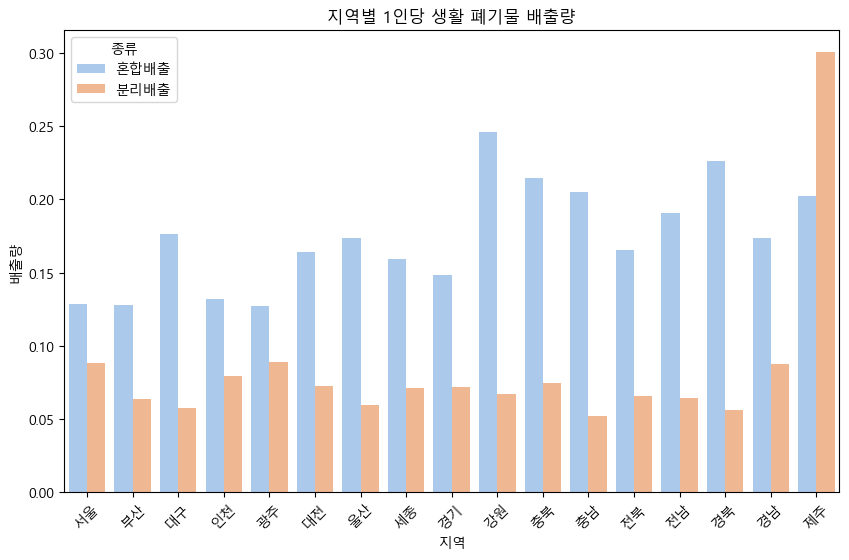

In [21]:

시별_발생데이터['인구별 배출량'] =  시별_발생데이터['2022년발생량'] / 시별_발생데이터['총인구수']
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 지역별 종류별 배출량을 막대 그래프로 시각화
sns.barplot(x='지역', y='인구별 배출량', hue='종류', data=시별_발생데이터, palette=colors )

# 그래프 제목 및 레이블 설정
plt.title('지역별 1인당 생활 폐기물 배출량')
plt.xlabel('지역')
plt.ylabel('배출량')
plt.xticks(rotation=45)  


# 그래프 표시
plt.show()

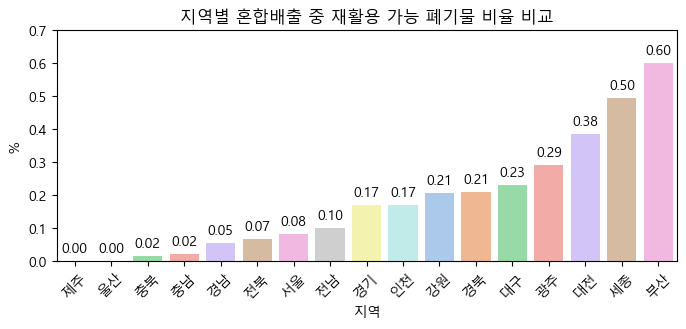

In [22]:
재활용_pivot= 시별_폐기물발생데이터.pivot_table(index=시별_폐기물발생데이터.index, columns='분류', values='총계-재활용')
재활용_pivot['지역'] = 재활용_pivot.index

재활용_pivot['혼합배출 중 재활용률'] = 재활용_pivot['혼합배출_소계']/df_pivot['혼합배출_소계']
재활용_pivot = 재활용_pivot.sort_values('혼합배출 중 재활용률')


plt.figure(figsize=(8, 3))
barplot = sns.barplot(x ='지역', y='혼합배출 중 재활용률', data=재활용_pivot,  palette='pastel')

# 막대 위에 숫자 표시
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')
# 제목 및 레이블 설정
plt.title('지역별 혼합배출 중 재활용 가능 폐기물 비율 비교')
plt.xlabel('지역')
plt.ylabel('%')
plt.ylim((0.0,0.7))

plt.xticks(rotation=45)
plt.show()

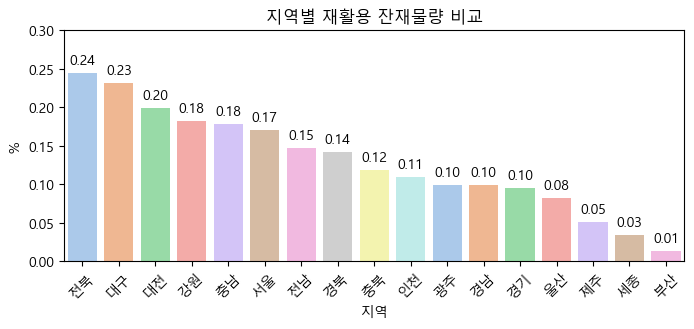

In [23]:
df_pivot['재활용잔재물'] = df_pivot['분리배출_재활용 잔재물']/df_pivot['분리배출_소계']
df_pivot['지역'] = df_pivot.index

plt.figure(figsize=(8, 3))
df_pivot = df_pivot.sort_values('재활용잔재물', ascending=False)
barplot = sns.barplot(x ='지역', y='재활용잔재물', data=df_pivot,  palette='pastel')
# 막대 위에 숫자 표시
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')
# 제목 및 레이블 설정
plt.title('지역별 재활용 잔재물량 비교')
plt.ylim((0.0, 0.30))
plt.xlabel('지역')
plt.ylabel('%')
plt.xticks(rotation=45)
plt.show()

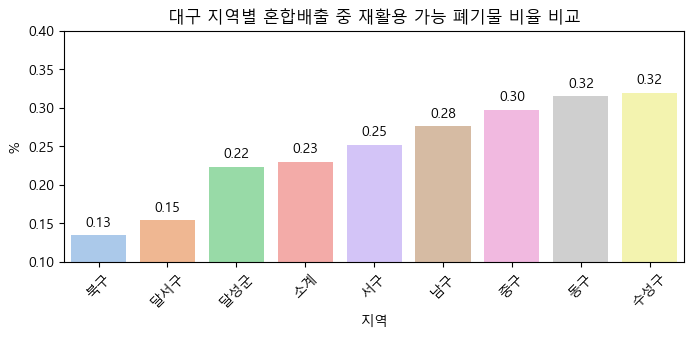

In [24]:

대구_폐기물발생 = 전국폐기물발생_처리현황.xs(level=0,key='대구')
대구_폐기물발생.columns =tuple([(multicolumn(x)) for x in 대구_폐기물발생.columns])
대구_폐기물발생 = 대구_폐기물발생.reset_index(level=(1, 2,3))
대구_폐기물발생=대구_폐기물발생.replace({'종량제방식 등 혼합배출':'혼합배출',
                                        '재활용 \n가능자원\n 분리배출':'분리배출',
                                        '음식물류 폐기물 분리배출':'음식물'})

대구_폐기물발생['분류']=대구_폐기물발생.apply(create_col, axis=1)


대구_df_pivot = 대구_폐기물발생.pivot_table(index=대구_폐기물발생.index, columns='분류', values='2022년발생량')

대구_재활용_pivot= 대구_폐기물발생.pivot_table(index=대구_폐기물발생.index, columns='분류', values='총계-재활용')
대구_재활용_pivot['지역'] = 대구_재활용_pivot.index

대구_재활용_pivot['혼합배출 중 재활용률'] = 대구_재활용_pivot['혼합배출_소계']/대구_df_pivot['혼합배출_소계']
대구_재활용_pivot = 대구_재활용_pivot.sort_values('혼합배출 중 재활용률')


plt.figure(figsize=(8, 3))
barplot = sns.barplot(x ='지역', y='혼합배출 중 재활용률', data=대구_재활용_pivot,  palette='pastel')

# 막대 위에 숫자 표시
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')
# 제목 및 레이블 설정
plt.title('대구 지역별 혼합배출 중 재활용 가능 폐기물 비율 비교')

plt.ylim((0.10, 0.40))

plt.xlabel('지역')
plt.ylabel('%')
plt.xticks(rotation=45)
plt.show()


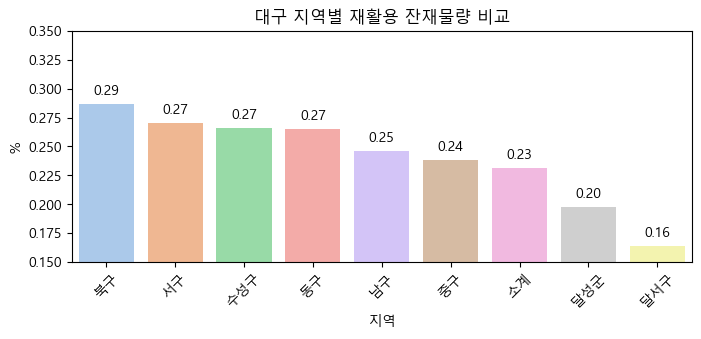

In [25]:
대구_df_pivot['재활용잔재물'] = 대구_df_pivot['분리배출_재활용 잔재물']/대구_df_pivot['분리배출_소계']
대구_df_pivot['지역'] = 대구_df_pivot.index

plt.figure(figsize=(8, 3))
대구_df_pivot = 대구_df_pivot.sort_values('재활용잔재물', ascending=False)
barplot = sns.barplot(x ='지역', y='재활용잔재물', data=대구_df_pivot,  palette='pastel')
# 막대 위에 숫자 표시
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')
# 제목 및 레이블 설정
plt.title('대구 지역별 재활용 잔재물량 비교')
plt.xlabel('지역')
plt.ylabel('%')
plt.ylim((0.15,0.35))
plt.xticks(rotation=45)
plt.show()

## 폐기물 발생과 매립량, 에너지 회수량 분석

In [26]:
지역별_처리량 = pd.DataFrame(
    {'소각':공공소각_지역별_소계['2022년 처리량'], 
     '기타': 공공기타_지역별_소계['2022년 처리량'], 
     '매립':공공매립_지역별_소계['2022년 매립량(생활/사업장폐기물)(ton)']
     })
지역별_처리량 = 지역별_처리량.fillna(0)
지역별_처리량['총 처리량'] = 지역별_처리량['소각'] +지역별_처리량['매립'] + 지역별_처리량['기타']


지역별_매립량 = pd.DataFrame(
    {'총폐기물발생량' : 지역별_발생량합계,
     '소각_잔재물-매립':공공소각_지역별_소계['잔재물 발생 및 처리현황(톤/년)-매립'], 
     '기타_잔재물-매립': 공공기타_지역별_소계['잔재물 발생 및 처리현황(톤/년)-매립'], 
     '매립':공공매립_지역별_소계['2022년 매립량(생활/사업장폐기물)(ton)'],
     })
지역별_매립량['지역'] = 지역별_매립량.index
지역별_매립량 = 지역별_매립량.fillna(0)
지역별_매립량['총 매립량'] = 지역별_매립량['소각_잔재물-매립'] + 지역별_매립량['기타_잔재물-매립'] +지역별_매립량['매립']
지역별_매립량['발생량 대 최종매립비율'] = 지역별_매립량['총 매립량']/지역별_매립량['총폐기물발생량']
지역별_매립량 = 지역별_매립량.sort_values('발생량 대 최종매립비율', ascending=False)



지역별_에너지회수량 = pd.DataFrame(
    {'총폐기물처리량' : 지역별_처리량['총 처리량'],
     '소각에너지 소계': 공공소각_지역별_소계['에너지발생량(Gcal)'],
     '매립에너지 소계': 공공매립_지역별_소계['발생가스 총포집량 중 메탄가스량(N㎥/년)'],
     '기타에너지 소계': 공공기타_지역별_소계['발생가스 이용현황-발생가스 포집량-발생가스 총포집량 중메탄가스량(N㎥/년)']
    }
)
지역별_에너지회수량 = pd.concat([지역별_매립량, 지역별_에너지회수량], axis=1)
지역별_에너지회수량['지역'] = 지역별_에너지회수량.index
지역별_에너지회수량 = 지역별_에너지회수량.fillna(0)

지역별_에너지회수량['총 에너지회수량'] = 지역별_에너지회수량['소각에너지 소계'] + 지역별_에너지회수량['매립에너지 소계'] + 지역별_에너지회수량['기타에너지 소계']
지역별_에너지회수량['처리량 대 에너지회수'] = (지역별_에너지회수량['총 에너지회수량'])/지역별_에너지회수량['총폐기물처리량']
지역별_에너지회수량['처리량 대 에너지회수'] =df_scaler(지역별_에너지회수량['처리량 대 에너지회수'])
지역별_에너지회수량 = 지역별_에너지회수량.sort_values('처리량 대 에너지회수', ascending=False)




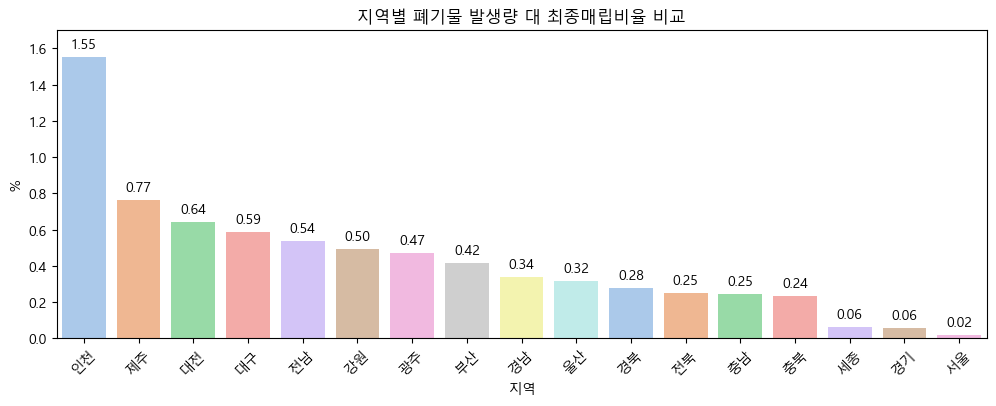

In [27]:
## 지역별 매립량 비교
plt.figure(figsize=(12, 4))
barplot = sns.barplot(x=지역별_매립량['지역'], y='발생량 대 최종매립비율', data=지역별_매립량,  palette='pastel')
# 막대 위에 숫자 표시
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')
# 제목 및 레이블 설정
plt.title('지역별 폐기물 발생량 대 최종매립비율 비교')
plt.ylim((0,1.7))
plt.xlabel('지역')
plt.ylabel('%')
plt.xticks(rotation=45)  # 
plt.show()

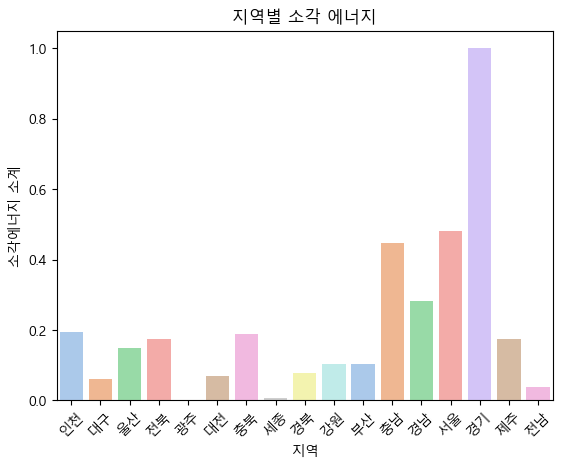

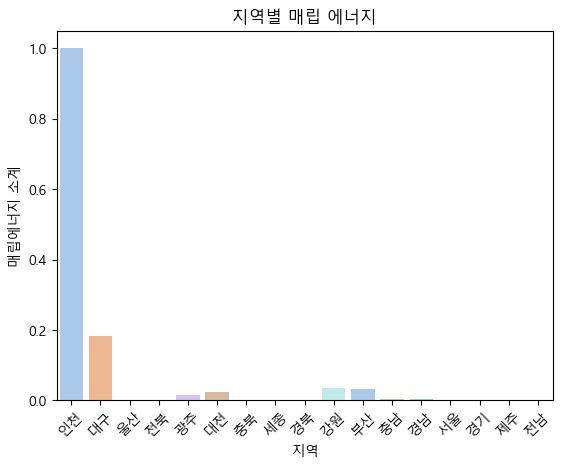

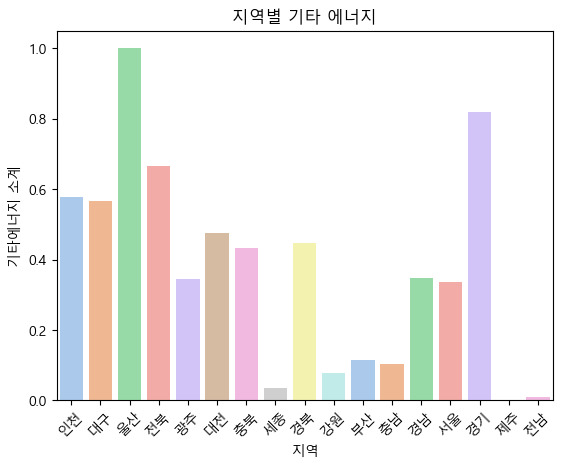

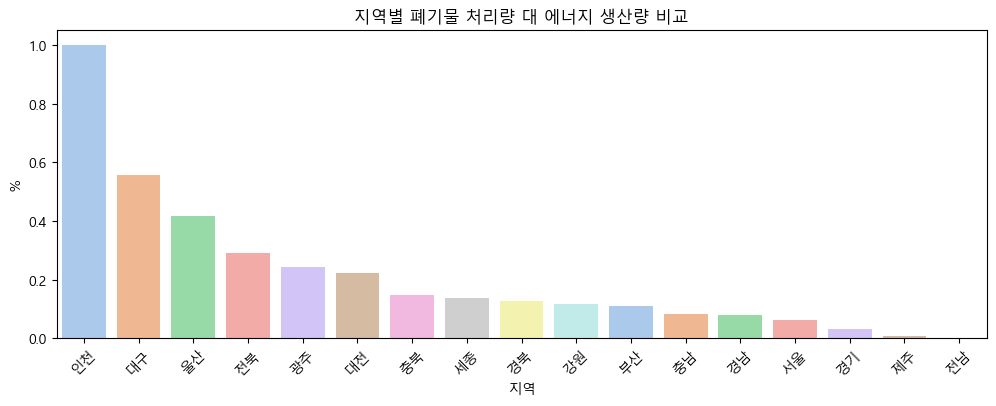

In [28]:
# 지역별 에너지 회수량 비교
지역별_에너지회수량['소각에너지 소계'] = (지역별_에너지회수량['소각에너지 소계']-지역별_에너지회수량['소각에너지 소계'].min()) / (지역별_에너지회수량['소각에너지 소계'].max()-지역별_에너지회수량['소각에너지 소계'].min())
지역별_에너지회수량['매립에너지 소계'] = (지역별_에너지회수량['매립에너지 소계']-지역별_에너지회수량['매립에너지 소계'].min()) / (지역별_에너지회수량['매립에너지 소계'].max()-지역별_에너지회수량['매립에너지 소계'].min())
지역별_에너지회수량['기타에너지 소계'] = (지역별_에너지회수량['기타에너지 소계']-지역별_에너지회수량['기타에너지 소계'].min()) / (지역별_에너지회수량['기타에너지 소계'].max()-지역별_에너지회수량['기타에너지 소계'].min())


sns.barplot(x='지역', y='소각에너지 소계',  data=지역별_에너지회수량, palette='pastel')
plt.xticks(rotation=45) 
plt.title('지역별 소각 에너지')
plt.show()


sns.barplot(x='지역', y='매립에너지 소계',  data=지역별_에너지회수량, palette='pastel')
plt.xticks(rotation=45) 
plt.title('지역별 매립 에너지')
plt.show()

sns.barplot(x='지역', y='기타에너지 소계',  data=지역별_에너지회수량, palette='pastel')
plt.xticks(rotation=45) 
plt.title('지역별 기타 에너지')
plt.show()


plt.figure(figsize=(12, 4))
barplot = sns.barplot(x=지역별_에너지회수량['지역'], y='처리량 대 에너지회수', data=지역별_에너지회수량,  palette='pastel')

        
plt.title('지역별 폐기물 처리량 대 에너지 생산량 비교')
plt.xlabel('지역')
plt.ylabel('%')
plt.xticks(rotation=45)  # x축 
plt.show()



In [29]:
# 최종 매립비율에 영향을 주는 것 분석
df = df_pivot.drop(columns='지역')
df = (df-df.mean(0)) / df.std(0)

corr = pd.concat([df, 지역별_매립량['발생량 대 최종매립비율']], axis = 1).corr()
corr = np.abs(corr)
# '처리량 대 에너지회수'와의 상관계수 추출
target_corr = corr['발생량 대 최종매립비율'].sort_values(ascending=False)

# 가장 높은 상관계수를 갖는 상위 10개 변수
top_10_corr = target_corr[1:5]  # 제외 항목: 자기 자신



print("최종 매립비율에 연관성 높은 폐기물: \n", top_10_corr)
corr = pd.concat([df, 지역별_에너지회수량['처리량 대 에너지회수']], axis = 1).corr()
corr = np.abs(corr)
target_corr = corr['처리량 대 에너지회수'].sort_values(ascending=False)

# 가장 높은 상관계수를 갖는 상위 5개 변수
top_10_corr = target_corr[1:5]  # 제외 항목: 자기 자신

print("최종 에너지 회수에 연관성 높은 폐기물: \n", top_10_corr)




최종 매립비율에 연관성 높은 폐기물: 
 혼합배출_불연성_폐금속류    0.458174
분리배출_기타          0.429864
혼합배출_불연성_폐유리류    0.410613
분리배출_폐가구류        0.407973
Name: 발생량 대 최종매립비율, dtype: float64
최종 에너지 회수에 연관성 높은 폐기물: 
 분리배출_영농폐기물_농약용기류    0.496352
분리배출_영농폐기물_폐비닐      0.423472
혼합배출_불연성_폐금속류       0.338236
분리배출_폐고무류           0.301007
Name: 처리량 대 에너지회수, dtype: float64
